# Hot regions

In [1]:
%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import math

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

import xpsi

from xpsi.global_imports import _c, _G, _M_s, _dpr, gravradius, _csq, _km, _M_s, _2pi
from xpsi.cellmesh.mesh_tools import eval_cedeCentreCoords

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                 Version: 0.1                |
|---------------------------------------------|
|  https://thomasedwardriley.github.io/xpsi/  |
\=============================================/



Let's explore higher-complexity surface hot regions models.

In [2]:
class CustomSpacetime(xpsi.Spacetime):
    """ A custom spacetime object.
    
    The coordinate rotation frequency of the star is fixed.
    
    """

    def __init__(self, num_params, bounds, S):
        """
        :param int num_params: The number of spacetime parameters.
        :param float S: The coordinate rotation frequency (Hz).
        
        """
        super(CustomSpacetime, self).__init__(num_params, bounds)

        try:
            self._S = float(S)
        except TypeError:
            raise TypeError('Coordinate spin frequency must be a ``float``.')
        else:
            self._Omega = 2.0 * math.pi * S

In [3]:
bounds = [(0.1, 1.0), # (Earth) distance
          (1.0, 3.0), # gravitational mass
          (3.0 * gravradius(1.0), 16.0), # coordinate equatorial radius
          (0.001, math.pi/2.0)] # (Earth) inclination to rotation axis

spacetime = CustomSpacetime(num_params = 4, bounds = bounds, S = 300.0)

In [4]:
bounds = [(0.001, math.pi - 0.001),
          (0.001, math.pi/2.0 - 0.001),
          (5.1, 6.8)]

# a simple circular, simply-connected spot
primary = xpsi.HotRegion(num_params=3, bounds=bounds,
                            symmetry=True,
                            hole=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            do_fast=False)

bounds = [(0.001, math.pi - 0.001),
          (0.001, math.pi/2.0 - 0.001),
          (0.001, math.pi - 0.001),
          (0.0, 2.0),
          (0.0, 2.0*math.pi),
          (5.1, 6.8)]

# overlap of a non-radiating superseding member
# and a radiating ceding member
secondary = xpsi.HotRegion(num_params=6, bounds=bounds,
                              symmetry=True,
                              hole=True,
                              cede=False,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              is_secondary=True)

from xpsi import HotRegions

hot = HotRegions((primary, secondary))

Note that the ``{min,max}_sqrt_num_cells`` keyword arguments set the maximum number of elements that the vicinity of a hot region will be discretised into in both colatitude and azimuth.

Let's also explicitly fill the photosphere *elsewhere* with a simple radiation field. 

In [5]:
elsewhere = xpsi.Elsewhere(1, bounds=[(5.4,6.4)])

In [6]:
photosphere = xpsi.Photosphere(tag = 'all', hot = hot, elsewhere = elsewhere)

In [7]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

We will now define helper functions for plotting mesh representations, together with some plot settings. 

In [8]:
def plot_meshes(lines=(True,True),
                primary_ticks = (1,5),
                secondary_ticks = (1,5)):
    """ Plot representations of the cached meshes.
    
    Note that the lowest colatitude row of elements is plotted as the
    lowest row, so colatitude increases along the y-axis and azimuth
    increaes along the x-axis. This could be considered as spatially
    inverted if we were looking at the star whilst being oriented
    such that "up" is in the spin direction.
    
    """

    fig = plt.figure(figsize = (9, 19))

    gs = gridspec.GridSpec(2, 2, width_ratios=[50,1], wspace=0.1, hspace=0.1)
    ax = plt.subplot(gs[0,0])
    veneer(primary_ticks, primary_ticks, ax)

    # primary (lower colatitude) hot region
    z = hot.objects[0]._HotRegion__cellArea[0]/np.max(hot.objects[0]._HotRegion__cellArea[0])
    patches = plt.pcolormesh(z,
                             vmin = np.min(z),
                             vmax = np.max(z),
                             cmap = cm.magma,
                             linewidth = 1.0 if lines[0] else 0.0,
                             rasterized = True,
                             edgecolor='black')

    ax = plt.subplot(gs[1,0])
    veneer(secondary_ticks, secondary_ticks, ax)

    # secondary (higher colatitude) hot region
    z = hot.objects[1]._HotRegion__cellArea[0]/np.max(hot.objects[1]._HotRegion__cellArea[0])
    _ = plt.pcolormesh(z,
                       vmin = np.min(z),
                       vmax = np.max(z),
                       cmap = cm.magma,
                       linewidth = 1.0 if lines[1] else 0.0,
                       rasterized = True,
                       edgecolor='black')

    ax_cb = plt.subplot(gs[:,1])
    cb = plt.colorbar(patches,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label = r'cell area (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        
    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        
    axes.tick_params(which='major', colors='black', length=length)
    axes.tick_params(which='minor', colors='black', length=int(length/2))
    axes.xaxis.set_tick_params(which='both', width=lw)
    axes.yaxis.set_tick_params(which='both', width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')

Let's form a vector of parameter values in the *conventional* order expected by the ``Star`` instance and the other objects it encapsulates references to.

In [31]:
class Vector(object):
    """ The ordered parameter vector.
    
    This object should be useful if you are unfamiliar with
    the convention for parameter ordering. This object is
    configured only for ``Star`` object configured above.
    
    """
    
    def __init__(self, p=None):
        
        if p is not None:
            (self.D,
                self.M,
                self.R,
                self.i,
                self.spot_colat,
                self.spot_radius,
                self.spot_temp,
                self.super_colat,
                self.super_radius,
                self.hole_colat,
                self.hole_radius,
                self.hole_azi,
                self.super_temp,
                self.elsewhere_temp) = p
        else:
            # (Earth) distance
            self.D = 0.329
            # gravitational mass
            self.M = 1.4
            # coordinate equatorial radius
            self.R = 13.18
            # (Earth) inclination to rotation axis
            self.i = 1.0
            # primary hot region (spot) centre colatitude
            self.spot_colat = 2.19
            # primary spot angular radius
            self.spot_radius = 0.0792
            # primary spot effective temperature
            self.spot_temp = 6.11
            # secondary hot region superseding member (SSM) centre colatitude
            self.super_colat = math.pi/2.0
            # secondary hot region SSM angular radius
            self.super_radius = 0.32                
            # secondary hot region hole centre colatitude
            self.hole_colat = math.pi/2.0
            # secondary hot region hole angular radius
            self.hole_radius = 0.25
            # secondary hot region hole centre relative azimuth 
            self.hole_azi = 0.0
            # secondary hot region effective temperature
            self.super_temp = 6.12
            # elsewhere effective temperature
            self.elsewhere_temp = 5.6 
                
    def __call__(self):
        """
        :returns: The parameter vector for the star.
        :rtype: *list*
        
        """
        
        return [self.D,
                self.M,
                self.R,
                self.i,
                self.spot_colat,
                self.spot_radius,
                self.spot_temp,
                self.super_colat,
                self.super_radius,
                self.hole_colat,
                self.hole_radius,
                self.hole_azi,
                self.super_temp,
                self.elsewhere_temp]
    
    @property
    def D(self):
        return self._D
        
    @D.setter
    def D(self, D):
        self._D = D
        
    @property
    def M(self):
        return self._M
        
    @M.setter
    def M(self, M):
        self._M = M
        
    @property
    def R(self):
        return self._R
        
    @R.setter
    def R(self, R):
        self._R = R
        
    @property
    def i(self):
        return self._i
        
    @i.setter
    def i(self, i):
        self._i = i
        
    @property
    def spot_colat(self):
        return self._spot_colat
        
    @spot_colat.setter
    def spot_colat(self, spot_colat):
        self._spot_colat = spot_colat
        
    @property
    def spot_radius(self):
        return self._spot_radius
        
    @spot_radius.setter
    def spot_radius(self, spot_radius):
        self._spot_radius = spot_radius
        
    @property
    def spot_temp(self):
        return self._spot_temp
        
    @spot_temp.setter
    def spot_temp(self, spot_temp):
        self._spot_temp = spot_temp
        
    @property
    def super_colat(self):
        return self._super_colat
        
    @super_colat.setter
    def super_colat(self, super_colat):
        self._super_colat = super_colat
        
    @property
    def super_radius(self):
        return self._super_radius
        
    @super_radius.setter
    def super_radius(self, super_radius):
        self._super_radius = super_radius
        
    @property
    def hole_colat(self):
        return self._hole_colat
        
    @hole_colat.setter
    def hole_colat(self, hole_colat):
        self._hole_colat = hole_colat
    
    @property
    def hole_radius(self):
        return self._hole_radius
        
    @hole_radius.setter
    def hole_radius(self, hole_radius):
        self._hole_radius = hole_radius
        
    @property
    def hole_azi(self):
        return self._hole_azi
        
    @hole_azi.setter
    def hole_azi(self, hole_azi):
        self._hole_azi = hole_azi
        
    @property
    def super_temp(self):
        return self._super_temp
        
    @super_temp.setter
    def super_temp(self, super_temp):
        self._super_temp = super_temp
        
    @property
    def elsewhere_temp(self):
        return self._elsewhere_temp
        
    @elsewhere_temp.setter
    def elsewhere_temp(self, elsewhere_temp):
        self._elsewhere_temp = elsewhere_temp

In [32]:
v = Vector()

We now prepare the star for pulse integration. In statistical contexts the likelihood function places this call automatically. The preparation involves embedding hot region objects into the photosphere (that also radiates elsewhere), by constructing element (or cell) meshes and precomputing ray mapping information for image integration. We place a call to our helper function to plot the meshes constructed: the mesh for the primary hot region is rendered in the topmost panel, with colour representing the proper area covered by the hot region within a given element. This area weights the pulse generated by an infinitesimal radiating element located at the proper-area-weighted centre of the element. The mesh associated with the secondary hot region is rendered in the bottommost panel.

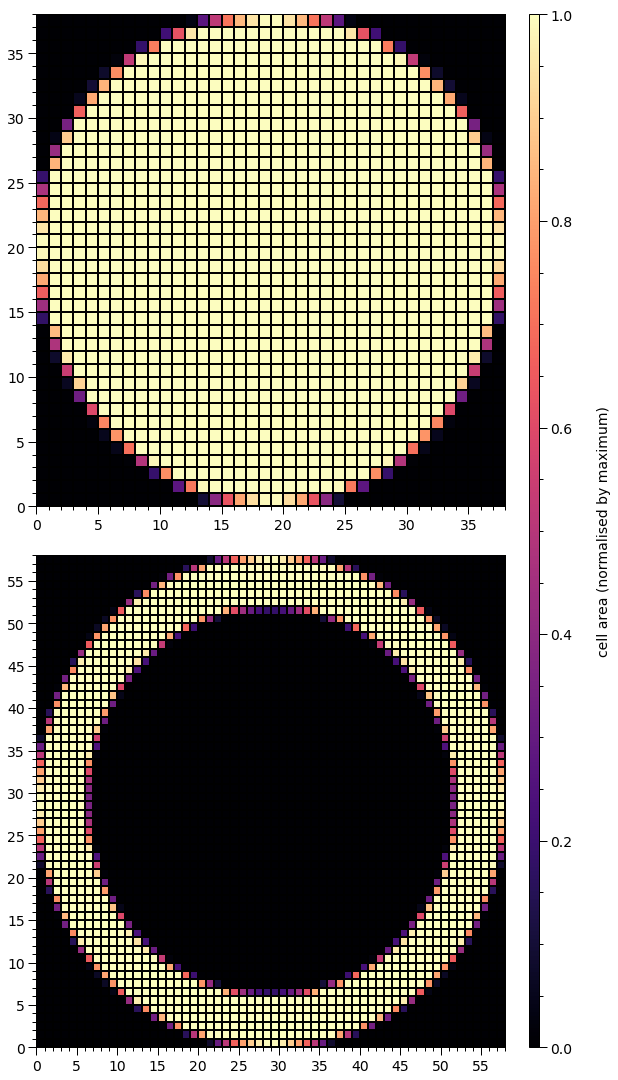

In [33]:
star.update(v())

plot_meshes()

We have a ring for secondary hot region. The hole would be automatically filled with the radiation field *elsewhere*, which might, e.g., be much cooler.

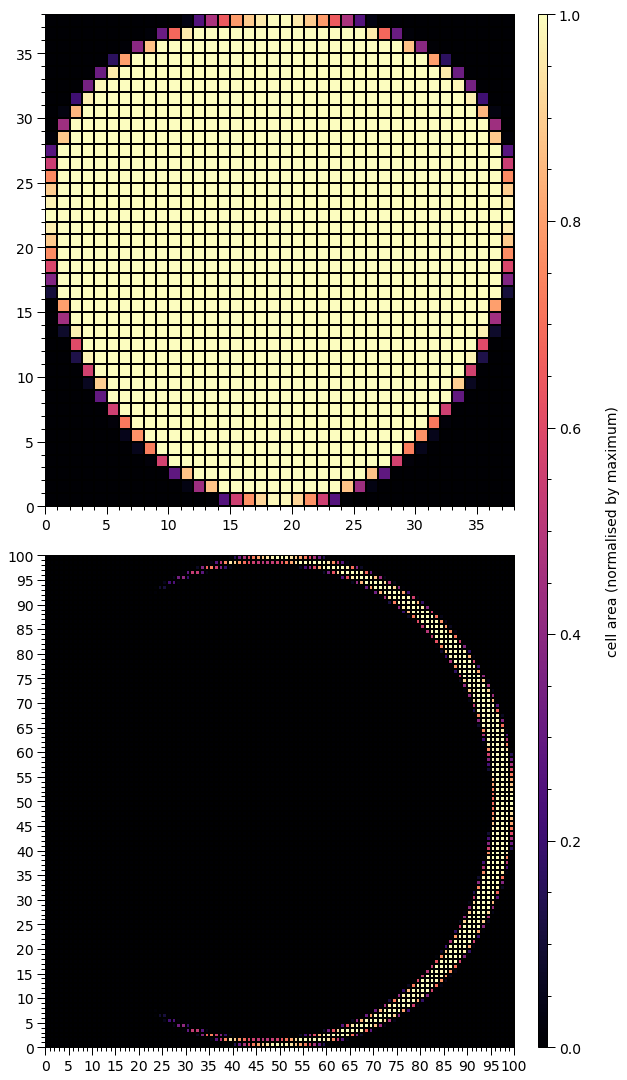

In [37]:
v.spot_radius = 0.25   # increase the primary spot angular radius
v.hole_radius = 0.31   # increase the angular radius of the hole
v.hole_azi = -0.02     # introduce a finite azimuthal hole offset

star.update(v())

plot_meshes()

We have a crescent that is symmetric about the equator. Note that, confusingly, the *hole* is not actually a hole. The current object naming convention in the source code means that this is referred to as a hole, although it is not topologically true. A better way to think about this configuration is to consider a superseding member that supersedes a ceding member with the *elsewhere* radiation field.

Given that the superseding member is not a topological hole, the resulting crescent has *terminal points* or *horns*. As one approaches the horns around the crescent, the cell areas approach zero, and the two cells containing the two terminal points, and the adjacent cells cannot be resolved in colour from the cells that have zero coverage of the hot region. We can pick out these cells at the horns by setting a uniform colour for cells of finite area:

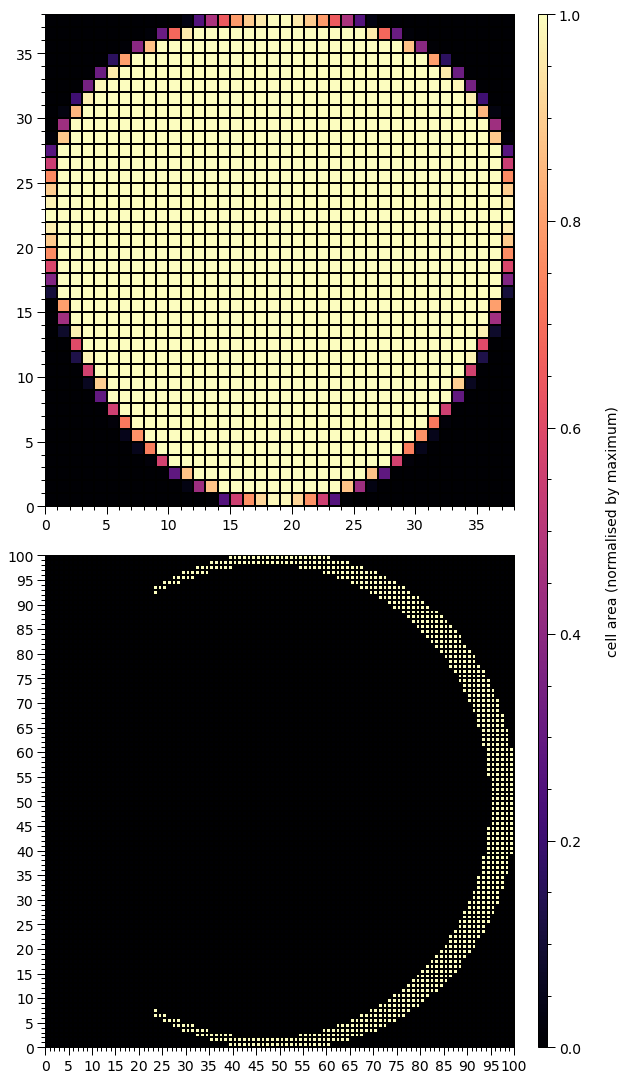

In [38]:
h = hot.objects[1]

h._super_cellArea[h._super_cellArea > 0.0] = 1.0

plot_meshes()

We can now see all cells with finite hot region coverage, and the symmetry is perhaps clearer.

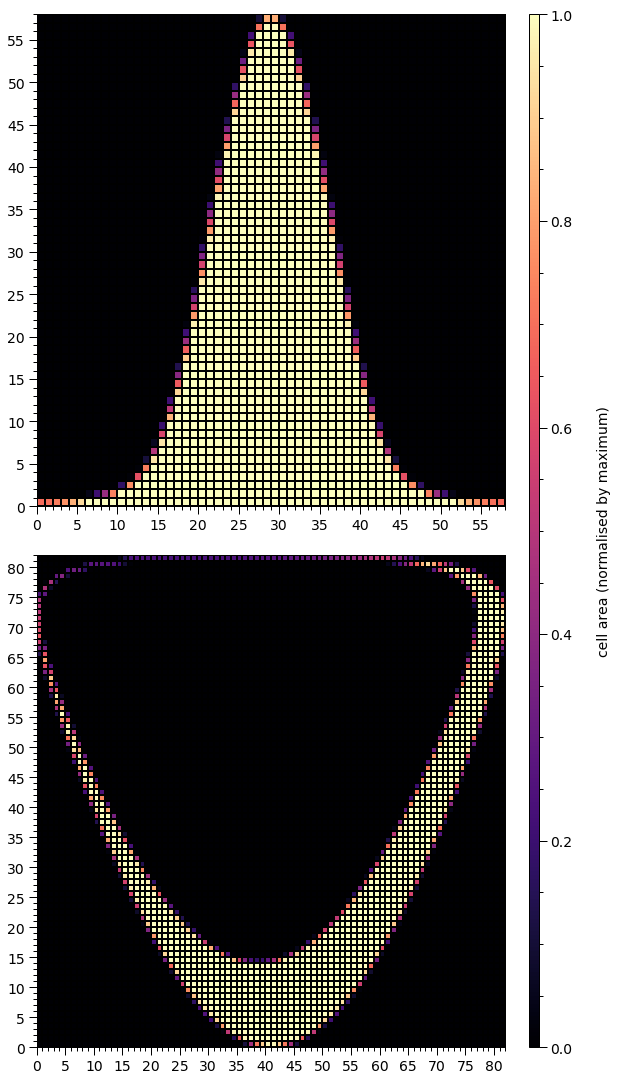

In [39]:
v.spot_colat = 2.9     # increase the colatitude of the primary spot centre
v.spot_radius = 0.3    # increase the angular radius of the primary spot
v.super_colat = 2.72   # this is not equal
v.hole_colat = 2.75    # to this anymore
v.hole_radius = 0.284  #
v.hole_azi = -0.0483   # increase the magnitude of hole azimuthal offset

star.update(v())

plot_meshes()

Note that a fundamental property of the topmost mesh has now changed: the boundary in azimuth is periodic because the spot encompasses a pole (the southern rotational pole), whilst the lower boundary in colatitude is actually a coordinate singularity. The boundary in azimuth for the bottommost mesh is *not* periodic. The *hole* is close enough to being a topological hole that we cannot distinguish whether or not it is from the mesh, and would need to calulate the sum of the angular radius of the hole with the angular separation between the centres.

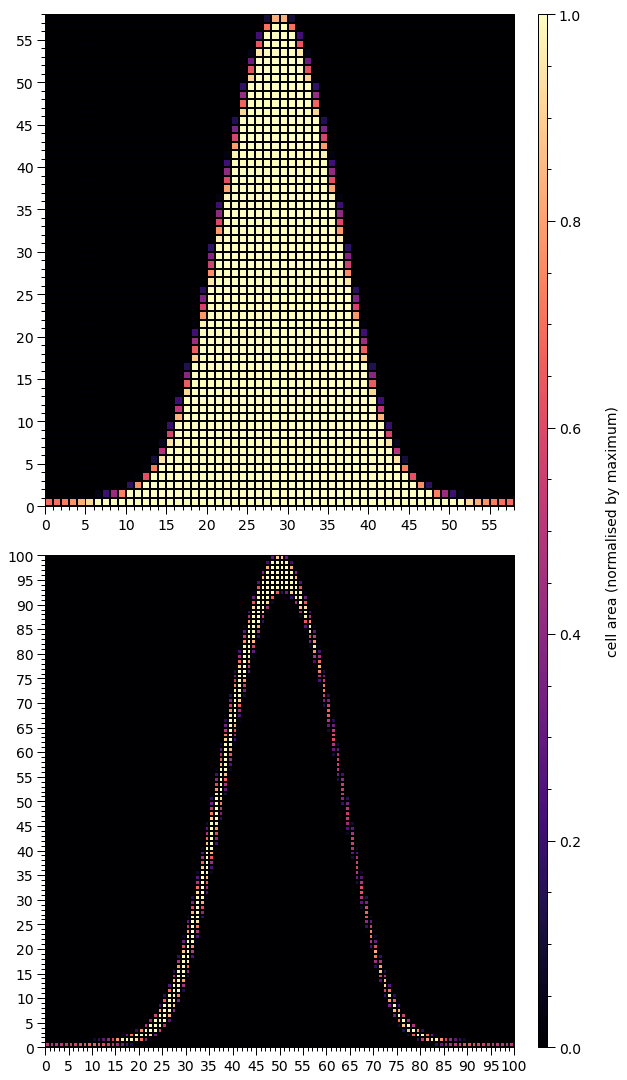

In [42]:
v.spot_colat = math.pi - 2.9   # reflect primary spot w.r.t equator
v.super_colat = 2.87           # increase SSM centre colatitude
v.hole_colat = v.super_colat   # increase hole centre colatitude
v.hole_radius = 0.3            # increase the hole angular radius
v.hole_azi *= -1.0             # positive hole offset

star.update(v())

plot_meshes()

Note that although the primary spot was reflected about the equator, and now encompasses the northern rotation pole, the mesh does not look as though it has been reflected. Under the hood, the mesh for the primary spot encompassing the southern rotational pole is constructed as reflection about the equator, and then the mesh of colatitudes, which is not plotted but has the same shape as the mesh of proper areas (plotted), is transformed via $\theta\mapsto\pi-\theta$, leaving other reflection-symmetric properties intact. 

The mesh for the secondary hot region has now joined that of the primary in having a periodic boundary in azimuth. Note that the hole also encompasses the southern rotational pole.

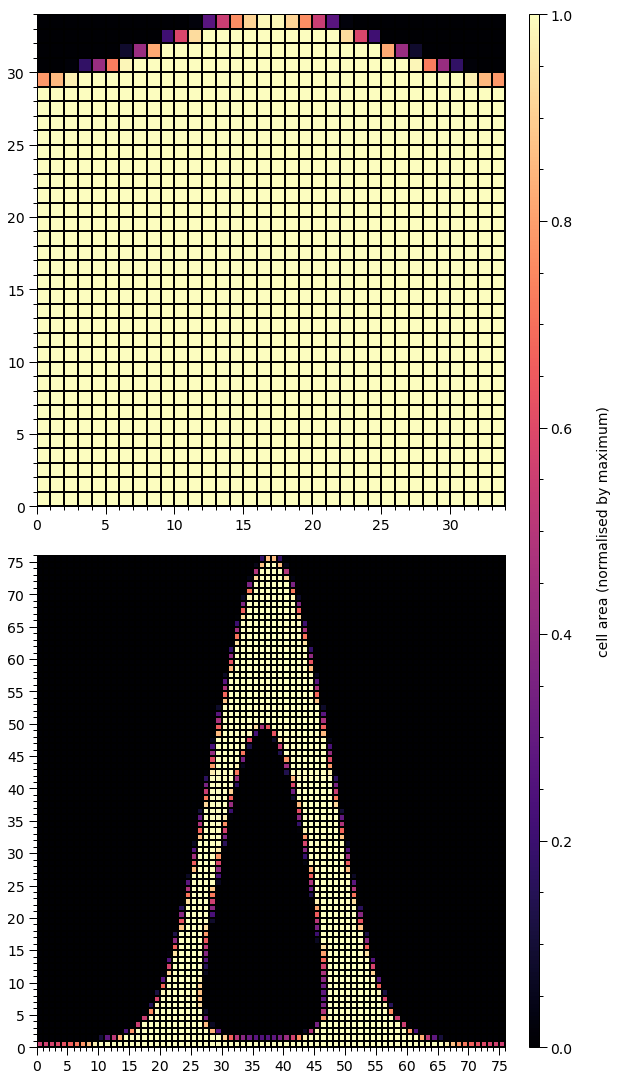

In [15]:
p = [0.328978844399083370E+00,
        0.140337033600940120E+01,
        0.133784624585842025E+02,
        0.100434973113637094E+01,
        math.pi - 0.01, # move primary spot centre almost to south pole 
        0.3,
        0.610655622382022134E+01,
        0.27, # move secondary hot region to encompass north pole
        0.32,
        0.275,
        0.2, # decrease the angular radius of the hole
        -0.1, # increase magnitude of hole azimuthal offset
        0.611730491798804454E+01,
        5.6]

star.update(p)

plot_meshes()

The primary spot centre is now almost coincident with a pole, with the angular separation between pole and centre much smaller than the angular radius of the spot. Meanwhile, the hole in the secondary hot region is a topological hole, but does not encompass a pole, whilst the outer boundary of the resulting ring *does*.

Let's increase the resolution for one of the examples above to some ridiculous level that is not even accurately rendered:

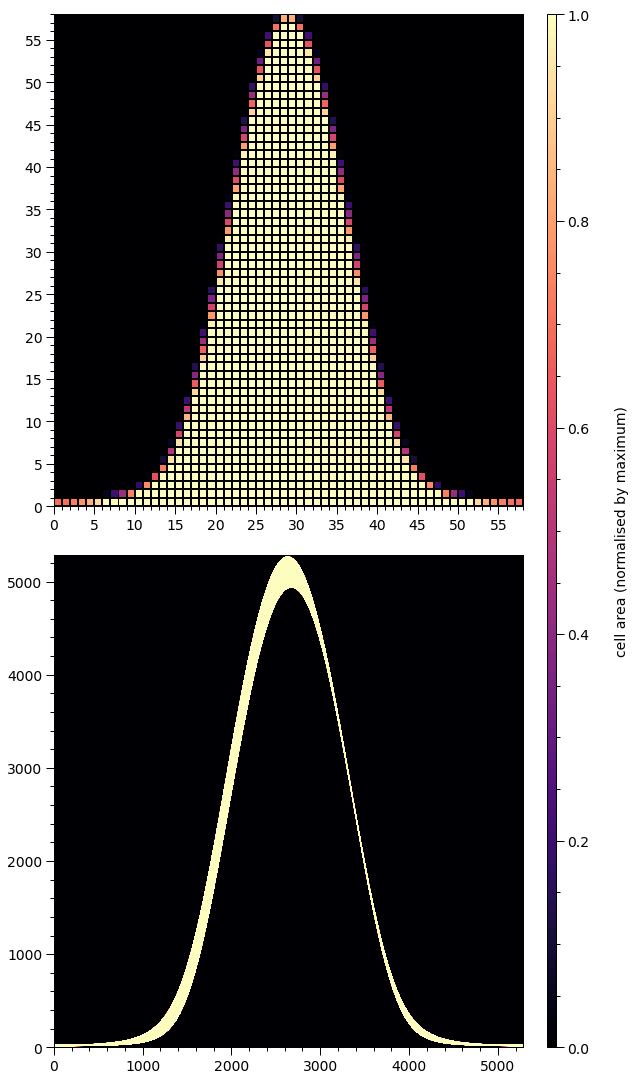

In [18]:
p = [0.328978844399083370E+00,
        0.140337033600940120E+01,
        0.133784624585842025E+02,
        0.100434973113637094E+01,
        math.pi - 2.9, # reflect primary spot w.r.t equator
        0.3,
        0.610655622382022134E+01,
        2.87, # increase SSM centre colatitude
        0.32,
        2.87, # increase hole centre colatitude
        0.3, # increase the hole angular radius
        0.483260905056053860E-01, # positive hole offset
        0.611730491798804454E+01,
        5.6]

h = hot.objects[1]

h.set_num_cells(sqrt_num_cells=1000, max_sqrt_num_cells=10000)

star.update(p)

plot_meshes(lines=(True, False), secondary_ticks=None)

In [ ]:
def transform(p):
    """ Transform a parameter vector from a useful space to another.
    
    Specifically, the input vector ``p`` has a subvector constituted by:
    
        * 
        *
        *
        
    """
    
    p[7], p[11] = eval_cedeCentreCoords(p[9], p[7], p[11])

    p[11] *= -1.0

    return p

In [ ]:
p = [0.328978844399083370E+00,
        0.140337033600940120E+01,
        0.133784624585842025E+02,
        0.100434973113637094E+01,
        3.1,
        0.3,
        0.610655622382022134E+01,
        0.0,
        0.32,
        math.pi/2,
        0.31,
        0.0,
        0.611730491798804454E+01,
        5.6]

star.update(transform(p))

plot_meshes()